In [1]:
import os
import time
import torch
import math
import torchvision
from torchvision import transforms as transforms
from torch import nn
from torch.nn import functional as F
from math import cos,pi

import matplotlib.pyplot as plt
import numpy as np
import random

torch.cuda.empty_cache()

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.manual_seed(17)
torch.cuda.manual_seed_all(17)

aug_train = transforms.Compose([
    transforms.RandomCrop(32,padding=4,padding_mode='reflect'),
    transforms.RandomHorizontalFlip(), # 水平翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

aug_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4244, 0.4146, 0.3836), (0.2539, 0.2491, 0.2420)) # normalization
    ])

trainingdata = torchvision.datasets.CIFAR10('./CIFAR10',train=True,download=True,transform=aug_train)
# testdata = torchvision.datasets.CIFAR10('./CIFAR10',train=False,download=True,transform=transforms.ToTensor())
# print(len(trainingdata),len(testdata))

Files already downloaded and verified


In [4]:
def load_data(is_train,aug,batch_size):
    dataset = torchvision.datasets.CIFAR10('./CIFAR10',train=is_train,download=True,transform=aug)
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=is_train)
    return dataloader

batch_size = 256 # param
trainDataLoader = load_data(is_train=True,aug=aug_train,batch_size=batch_size)
testDataLoader = load_data(is_train=False,aug=aug_test,batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32]) 6


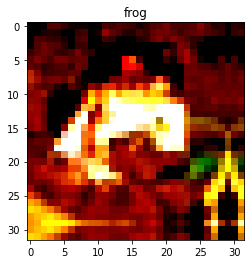

In [5]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

image,label = trainingdata[0]
print(image.shape, label)

%matplotlib inline
plt.imshow(image.numpy().transpose(1,2,0))
plt.title(str(classes[label]))
plt.show()

In [6]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
#         self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(1024, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
#         print(x.shape)
        out = F.relu(self.bn1(self.conv1(x)))
#         print(out.shape)
        out = self.layer1(out)
#         print(out.shape)
        out = self.layer2(out)
#         print(out.shape)
        out = self.layer3(out)
#         print(out.shape)
#         out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
#         print(out.shape)
        out = out.view(out.size(0), -1)
#         print(out.shape)
        out = self.linear(out)
        return out
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out',nonlinearity='relu') # weight initialization
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
            elif isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,std=1e-3)
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)

def project1_model():
#     return ResNet(BasicBlock, [2, 2, 2, 2])
    return ResNet(BasicBlock, [3, 3, 3])

# model1 = nn.Sequential(project1_model(), nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(512, 10)).cuda()
model1 = project1_model().cuda()
model1.init_weights()

In [7]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    # torch.numel() returns number of elements in a tensor

print(count_parameters(model1))

4335434


In [8]:
# X = torch.rand(size=(1, 3, 32, 32)).cuda()
# for layer in model1:
#   X = layer(X)
#   print(layer.__class__.__name__,'output shape:\t', X.shape)

In [9]:
num_epochs = 500 # param
epoch_start = 0
path = 'resnet_aug_3block_adam_batch256_lr0001.pt'

train_loss_history = []
test_loss_history = []
train_accuracy_history = []
test_accuracy_history = []

Loss = torch.nn.CrossEntropyLoss()

lr = 0.001
lr_min=0.001
momentum = 0.9
nesterov = True
#optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=momentum,nesterov=nesterov)
# optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=0.9,weight_decay=5e-4) # changable optimizer
# optimizer = torch.optim.SGD(model1.parameters(),lr=lr,momentum=0.9) # changable optimizer
optimizer = torch.optim.Adam(model1.parameters(),lr=lr, betas=(0.9,0.999), eps=1e-08, amsgrad=False) # changable optimize


if os.path.exists(path):
    checkpoint = torch.load(path)
    print('Read model from checkpoint')
    model1.cuda().load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_start = checkpoint['epoch']
    Loss = checkpoint['Loss']
    train_loss_history = checkpoint['train_loss_history']
    test_loss_history = checkpoint['test_loss_history']
    train_accuracy_history = checkpoint['train_accuracy_history']
    test_accuracy_history = checkpoint['test_accuracy_history']
    print('Restart from epoch',epoch_start)
    

for epoch in range(epoch_start+1, num_epochs+1):
    timestart = time.time()

    train_loss = 0.0
    test_loss = 0.0
    train_accuracy = 0.0
    test_accuracy = 0.0

    for i, data in enumerate(trainDataLoader):
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        predicted_output = model1.cuda()(images)
        fit = Loss(predicted_output,labels)
        fit.backward()
        optimizer.step()
        train_loss += fit.item()
        train_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()

    for i, data in enumerate(testDataLoader):
        with torch.no_grad():
            images, labels = data
            images = images.cuda()
            labels = labels.cuda()
            predicted_output = model1.cuda()(images)
            fit = Loss(predicted_output,labels)
            test_loss += fit.item()
            test_accuracy += (torch.eq(torch.max(predicted_output,1)[1],labels).sum()/len(labels)*100).data.cpu().numpy()


    train_loss = train_loss/len(trainDataLoader)
    test_loss = test_loss/len(testDataLoader)
    train_accu = train_accuracy/len(trainDataLoader)
    test_accu = test_accuracy/len(testDataLoader)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_accuracy_history.append(train_accu)
    test_accuracy_history.append(test_accu)
    print('Epoch %s, Train loss %s, Test loss %s, Train accuracy %s, Test accuracy %s, Cost %s s'%(epoch,
                                                                                                   train_loss,test_loss,
                                                                                                   train_accu,test_accu,
                                                                                                   time.time()-timestart))

    if epoch % 5 == 0 and epoch != 0:
        torch.save({'epoch':epoch,
          'model_state_dict':model1.cuda().state_dict(),
          'optimizer_state_dict':optimizer.state_dict(),
          'Loss':Loss,
          'train_loss_history':train_loss_history,
          'test_loss_history':test_loss_history,
          'train_accuracy_history':train_accuracy_history,
          'test_accuracy_history':test_accuracy_history},path)
        print('Model saved in epoch %s'%(epoch))

Epoch 1, Train loss 1.4847792557307653, Test loss 1.11072129458189, Train accuracy 44.2741549744898, Test accuracy 59.638671875, Cost 104.69371032714844 s
Epoch 2, Train loss 1.0050178161081003, Test loss 0.8167445510625839, Train accuracy 63.966438137755105, Test accuracy 70.927734375, Cost 109.97765731811523 s
Epoch 3, Train loss 0.7953114217641403, Test loss 0.6623742491006851, Train accuracy 71.98301977040816, Test accuracy 76.728515625, Cost 108.06261563301086 s
Epoch 4, Train loss 0.6653783921988643, Test loss 0.6106591209769249, Train accuracy 76.84311224489795, Test accuracy 78.33984375, Cost 107.66402268409729 s
Epoch 5, Train loss 0.573116774157602, Test loss 0.559951139241457, Train accuracy 80.07374043367346, Test accuracy 81.142578125, Cost 105.66792321205139 s
Model saved in epoch 5
Epoch 6, Train loss 0.5019832148539777, Test loss 0.4915528312325478, Train accuracy 82.4625318877551, Test accuracy 83.14453125, Cost 105.51487231254578 s
Epoch 7, Train loss 0.45206752237008

Epoch 52, Train loss 0.04840046089446666, Test loss 0.36818518824875357, Train accuracy 98.34382971938776, Test accuracy 91.796875, Cost 107.56939911842346 s
Epoch 53, Train loss 0.049306669647862414, Test loss 0.35260074473917485, Train accuracy 98.2828443877551, Test accuracy 91.81640625, Cost 105.386146068573 s
Epoch 54, Train loss 0.043313349594780226, Test loss 0.36209413446485994, Train accuracy 98.54113520408163, Test accuracy 92.060546875, Cost 105.61586427688599 s
Epoch 55, Train loss 0.03865855921544515, Test loss 0.3513432934880257, Train accuracy 98.61248405612245, Test accuracy 92.0703125, Cost 105.5737555027008 s
Model saved in epoch 55
Epoch 56, Train loss 0.0425737283943335, Test loss 0.3655442163348198, Train accuracy 98.56385522959184, Test accuracy 92.080078125, Cost 103.28447484970093 s
Epoch 57, Train loss 0.04297344050636249, Test loss 0.3647598780691624, Train accuracy 98.42912946428571, Test accuracy 91.787109375, Cost 110.32200646400452 s
Epoch 58, Train loss 0

Epoch 102, Train loss 0.01953420097041609, Test loss 0.44111054576933384, Train accuracy 99.30046237244898, Test accuracy 91.71875, Cost 105.90950441360474 s
Epoch 103, Train loss 0.018649803956837525, Test loss 0.383958175778389, Train accuracy 99.38337053571429, Test accuracy 92.392578125, Cost 106.84682273864746 s
Epoch 104, Train loss 0.020266408246837328, Test loss 0.3870426330715418, Train accuracy 99.28970025510205, Test accuracy 92.5390625, Cost 105.93722653388977 s
Epoch 105, Train loss 0.022639835763565853, Test loss 0.3916158828884363, Train accuracy 99.27415497448979, Test accuracy 92.138671875, Cost 107.14197325706482 s
Model saved in epoch 105
Epoch 106, Train loss 0.021248834025903548, Test loss 0.4014403257519007, Train accuracy 99.29009885204081, Test accuracy 92.158203125, Cost 109.287832736969 s
Epoch 107, Train loss 0.019499474050648207, Test loss 0.39199090749025345, Train accuracy 99.33553890306122, Test accuracy 92.353515625, Cost 105.4820282459259 s
Epoch 108, T

Epoch 152, Train loss 0.014852681747229047, Test loss 0.4291966695338488, Train accuracy 99.47983099489795, Test accuracy 92.197265625, Cost 105.98049926757812 s
Epoch 153, Train loss 0.013437999241358163, Test loss 0.42757797315716745, Train accuracy 99.54360650510205, Test accuracy 92.802734375, Cost 107.92472577095032 s
Epoch 154, Train loss 0.011709608734236099, Test loss 0.45934876427054405, Train accuracy 99.61495535714286, Test accuracy 92.041015625, Cost 109.53679132461548 s
Epoch 155, Train loss 0.012862621121137043, Test loss 0.4360236365348101, Train accuracy 99.57310267857143, Test accuracy 92.421875, Cost 110.92884111404419 s
Model saved in epoch 155
Epoch 156, Train loss 0.01444198927730417, Test loss 0.4130973286926746, Train accuracy 99.53364158163265, Test accuracy 92.509765625, Cost 104.59473514556885 s
Epoch 157, Train loss 0.011871430608004389, Test loss 0.4374509032815695, Train accuracy 99.59701849489795, Test accuracy 92.197265625, Cost 106.00616383552551 s
Epoch

Epoch 202, Train loss 0.010637490026167552, Test loss 0.43574030697345734, Train accuracy 99.6631855867347, Test accuracy 92.919921875, Cost 110.01757001876831 s
Epoch 203, Train loss 0.00953481044921411, Test loss 0.4252819262444973, Train accuracy 99.67713647959184, Test accuracy 92.568359375, Cost 108.85786247253418 s
Epoch 204, Train loss 0.008393414508998607, Test loss 0.4416577354073524, Train accuracy 99.73094706632654, Test accuracy 92.822265625, Cost 104.14602184295654 s
Epoch 205, Train loss 0.010265727311035538, Test loss 0.40417985133826734, Train accuracy 99.66517857142857, Test accuracy 93.125, Cost 109.84706354141235 s
Model saved in epoch 205
Epoch 206, Train loss 0.006659210313361599, Test loss 0.4103651627898216, Train accuracy 99.78077168367346, Test accuracy 93.232421875, Cost 110.59283018112183 s
Epoch 207, Train loss 0.010776529601497139, Test loss 0.4080586824566126, Train accuracy 99.6109693877551, Test accuracy 92.900390625, Cost 105.04248404502869 s
Epoch 208,

Epoch 252, Train loss 0.007692811899167802, Test loss 0.46303917914628984, Train accuracy 99.74888392857143, Test accuracy 92.861328125, Cost 106.1104485988617 s
Epoch 253, Train loss 0.006047745154449201, Test loss 0.48176610805094244, Train accuracy 99.78874362244898, Test accuracy 92.802734375, Cost 104.76562404632568 s
Epoch 254, Train loss 0.006403260454320918, Test loss 0.4693407524377108, Train accuracy 99.79033801020408, Test accuracy 92.626953125, Cost 112.13410711288452 s
Epoch 255, Train loss 0.00853926929326286, Test loss 0.49666403867304326, Train accuracy 99.72098214285714, Test accuracy 92.421875, Cost 104.3258900642395 s
Model saved in epoch 255
Epoch 256, Train loss 0.006748408257222689, Test loss 0.4893918585032225, Train accuracy 99.76682079081633, Test accuracy 92.734375, Cost 109.14340662956238 s
Epoch 257, Train loss 0.0058866402985177976, Test loss 0.5072043746709823, Train accuracy 99.77080676020408, Test accuracy 92.431640625, Cost 107.07193398475647 s
Epoch 25

Epoch 302, Train loss 0.004246867791357081, Test loss 0.5025847535580397, Train accuracy 99.86447704081633, Test accuracy 93.2421875, Cost 107.50758695602417 s
Epoch 303, Train loss 0.005194528615568427, Test loss 0.4993933640420437, Train accuracy 99.83458227040816, Test accuracy 93.076171875, Cost 108.15771555900574 s
Epoch 304, Train loss 0.006369779972077112, Test loss 0.47775441259145734, Train accuracy 99.80229591836735, Test accuracy 92.75390625, Cost 111.75829601287842 s
Epoch 305, Train loss 0.007477478375852913, Test loss 0.4767235599458218, Train accuracy 99.74290497448979, Test accuracy 92.861328125, Cost 110.93450617790222 s
Model saved in epoch 305
Epoch 306, Train loss 0.005934276062872618, Test loss 0.49848419763147833, Train accuracy 99.79870854591837, Test accuracy 92.71484375, Cost 108.56674647331238 s
Epoch 307, Train loss 0.006456861693373978, Test loss 0.4637812737375498, Train accuracy 99.81425382653062, Test accuracy 92.900390625, Cost 107.30528807640076 s
Epoch

Epoch 352, Train loss 0.00438507422874251, Test loss 0.4651773937046528, Train accuracy 99.85411352040816, Test accuracy 92.83203125, Cost 106.56533193588257 s
Epoch 353, Train loss 0.0054836222970505106, Test loss 0.4779687121510506, Train accuracy 99.81823979591837, Test accuracy 93.291015625, Cost 107.06348276138306 s
Epoch 354, Train loss 0.0041072589442313874, Test loss 0.4507633138448, Train accuracy 99.86248405612245, Test accuracy 93.28125, Cost 105.61605596542358 s
Epoch 355, Train loss 0.004769360867111554, Test loss 0.4822900600731373, Train accuracy 99.86049107142857, Test accuracy 93.06640625, Cost 112.53887486457825 s
Model saved in epoch 355
Epoch 356, Train loss 0.00602788294536924, Test loss 0.4416583176702261, Train accuracy 99.79671556122449, Test accuracy 93.02734375, Cost 107.58598446846008 s
Epoch 357, Train loss 0.005302277191916875, Test loss 0.4359282050281763, Train accuracy 99.8226243622449, Test accuracy 93.388671875, Cost 107.42541885375977 s
Epoch 358, Tra

Epoch 402, Train loss 0.005439951731353417, Test loss 0.4833273567259312, Train accuracy 99.81465242346938, Test accuracy 92.83203125, Cost 76.4022765159607 s
Epoch 403, Train loss 0.005036928738523524, Test loss 0.46764951907098296, Train accuracy 99.82661033163265, Test accuracy 93.33984375, Cost 76.2119517326355 s
Epoch 404, Train loss 0.006325881818063825, Test loss 0.5115495409816504, Train accuracy 99.79591836734694, Test accuracy 92.978515625, Cost 76.22442579269409 s
Epoch 405, Train loss 0.006702215967194132, Test loss 0.4584424614906311, Train accuracy 99.79272959183673, Test accuracy 93.330078125, Cost 76.18977165222168 s
Model saved in epoch 405
Epoch 406, Train loss 0.003214372826964884, Test loss 0.4479020517319441, Train accuracy 99.90234375, Test accuracy 93.427734375, Cost 76.2152533531189 s
Epoch 407, Train loss 0.0029347409466082557, Test loss 0.46880511902272703, Train accuracy 99.90035076530613, Test accuracy 93.0078125, Cost 76.20346856117249 s
Epoch 408, Train lo

Epoch 452, Train loss 0.005513412923336341, Test loss 0.4842928577214479, Train accuracy 99.82461734693878, Test accuracy 93.18359375, Cost 74.48727607727051 s
Epoch 453, Train loss 0.004372912932272551, Test loss 0.482355323061347, Train accuracy 99.86049107142857, Test accuracy 93.291015625, Cost 52.939900159835815 s
Epoch 454, Train loss 0.0037497533630070096, Test loss 0.4769660424441099, Train accuracy 99.8764349489796, Test accuracy 93.134765625, Cost 52.92075705528259 s
Epoch 455, Train loss 0.0026432862143838994, Test loss 0.4992258928716183, Train accuracy 99.92625956632654, Test accuracy 93.193359375, Cost 53.107428789138794 s
Model saved in epoch 455
Epoch 456, Train loss 0.0024906152883775166, Test loss 0.48130907379090787, Train accuracy 99.92227359693878, Test accuracy 93.388671875, Cost 53.22837424278259 s
Epoch 457, Train loss 0.0031590181647608954, Test loss 0.48774539642035963, Train accuracy 99.90832270408163, Test accuracy 93.41796875, Cost 53.23397755622864 s
Epoch

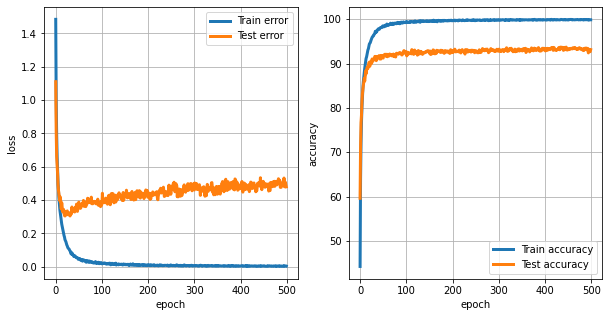

In [10]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(range(num_epochs),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(num_epochs),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(num_epochs),train_accuracy_history,'-',linewidth=3,label='Train accuracy')
plt.plot(range(num_epochs),test_accuracy_history,'-',linewidth=3,label='Test accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend()

In [11]:
print('Accuracy:',sum(test_accuracy_history[-5:])/5,100-sum(test_accuracy_history[-5:])/5)

Accuracy: 92.916015625 7.083984375
